This code: merges CSV files, shows which days and hours are in the collective database, creates df, converts x, y, values in to date-time and price including VAT and energy tax 2025 (0.1228). it should prompt for energy tax values, allowing to enter future tax values.

it shows the development of price predictions for the period -4 hours till 7 x 24 hours in the future.


In [42]:
# combine all price prediction files into a single database merged_df, which is also saved as CSV file "merged_data_price_preds.csv", located in same folder as this notebook
import os
import pandas as pd
import glob
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the folder containing the CSV files
folder_path = Path("oxygent_data")

# Get all CSV files in the folder
csv_files = list(folder_path.glob("*.csv")) + list(folder_path.glob("*.CSV"))

# Sort files based on timestamp in filename
csv_files.sort(key=lambda x: x.stem.split("_")[-1].replace(":", ""))

# Read and concatenate all CSV files
df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
        logging.info(f"Successfully read {file}")
    except Exception as e:
        logging.error(f"Error reading {file}: {e}")

if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)

    # Save the merged data
    output_file = "merged_data_price_preds.csv"
    merged_df.to_csv(output_file, index=False)
    logging.info(f"Merged {len(csv_files)} files into '{output_file}'")
else:
    logging.warning("No files were read successfully.")

2025-04-07 15:52:25,655 - INFO - Successfully read oxygent_data/prices_20250402_0000.CSV
2025-04-07 15:52:25,657 - INFO - Successfully read oxygent_data/prices_20250402_0600.CSV


2025-04-07 15:52:25,659 - INFO - Successfully read oxygent_data/prices_20250401_1245.CSV
2025-04-07 15:52:25,671 - INFO - Successfully read oxygent_data/prices_20250401_1300.CSV
2025-04-07 15:52:25,710 - INFO - Successfully read oxygent_data/prices_20250401_1733.CSV
2025-04-07 15:52:25,712 - INFO - Successfully read oxygent_data/prices_20250401_1800.CSV
2025-04-07 15:52:25,713 - INFO - Successfully read oxygent_data/time_series_data_20250328 19:45.csv
2025-04-07 15:52:25,715 - INFO - Successfully read oxygent_data/time_series_data_20250328 20:46.csv
2025-04-07 15:52:25,717 - INFO - Successfully read oxygent_data/time_series_data_20250328 21:09.csv
2025-04-07 15:52:25,720 - INFO - Successfully read oxygent_data/time_series_data_20250329 00:09.csv
2025-04-07 15:52:25,723 - INFO - Successfully read oxygent_data/time_series_data_20250329 03:09.csv
2025-04-07 15:52:25,727 - INFO - Successfully read oxygent_data/time_series_data_20250329 06:09.csv
2025-04-07 15:52:25,728 - INFO - Successfull

In [43]:
# Generate descriptive statistics for the merged data
descriptive_stats = merged_df.describe()

# Calculate the size of the DataFrame in MB
df_size_mb = merged_df.memory_usage(deep=True).sum() / (1024 * 1024)
# calculate number of unique timestamps representing timepoint of fetching price preds
unique_timestamps_count = merged_df['timestamp'].nunique()

# Print the descriptive statistics and DataFrame size
print(f"Size of merged_df: {df_size_mb:.2f} MB")
print(f"Number of unique timestamps: {unique_timestamps_count}")
print(descriptive_stats)


print(merged_df)

Size of merged_df: 135.76 MB
Number of unique timestamps: 767
                 x           y                         timestamp  subarray
count     779017.0  779017.000                            779017    779017
unique      1608.0    2141.000                               767        13
top     17418204.0       0.113  2025-03-21T12:51:03.955322+00:00         1
freq        1251.0    5710.000                              1918    144110
                 x        y                         timestamp subarray
0       17434620.0  0.09307  2025-04-02T00:00:04.880261+00:00        0
1       17434656.0  0.09084  2025-04-02T00:00:04.880261+00:00        0
2       17434692.0   0.0905  2025-04-02T00:00:04.880261+00:00        0
3       17434728.0  0.08871  2025-04-02T00:00:04.880261+00:00        0
4       17434764.0  0.09755  2025-04-02T00:00:04.880261+00:00        0
...            ...      ...                               ...      ...
779012  17435196.0      0.1  2025-03-25T19:00:04.963399+00:00     

In [44]:
# Data prep for pivot table to visualize extend of database
# Check if the 'timestamp' column has ISO 8601 format
try:
    pd.to_datetime(merged_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
    print("All timestamps are in ISO 8601 format.")
except ValueError:
    print("Some timestamps are not in ISO 8601 format.")
    # Identify rows with timestamps not in ISO 8601 format
    non_iso_rows = merged_df[~merged_df['timestamp'].str.match(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+[\+\-]\d{2}:\d{2}$')]

    # Print the rows with non-ISO 8601 timestamps
    if not non_iso_rows.empty:
        print("Rows with non-ISO 8601 timestamps:")
        print(non_iso_rows)
    else:
        print("All rows have ISO 8601 timestamps.")

    # Drop rows where 'subarray' column value is 'subarray'
    merged_df = merged_df[merged_df['subarray'] != 'subarray']
    print("rows with non numeric values for timestamp removed")

    # Recheck if the 'timestamp' column has ISO 8601 format
    try:
        pd.to_datetime(merged_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        print("Now all timestamps are in ISO 8601 format after dropping invalid rows.")
    except ValueError:
        print("Some timestamps are still not in ISO 8601 format.")


Some timestamps are not in ISO 8601 format.
Rows with non-ISO 8601 timestamps:
       x  y  timestamp  subarray
80539  x  y  timestamp  subarray
rows with non numeric values for timestamp removed
Now all timestamps are in ISO 8601 format after dropping invalid rows.


In [45]:

# Extract dates from the 'timestamp' column
merged_df['date_timestamp'] = pd.to_datetime(merged_df['timestamp']).dt.date
# Extract hour from the 'timestamp' column
merged_df['hour_timestamp'] = pd.to_datetime(merged_df['timestamp']).dt.hour


# Print df headers
print(merged_df)



                 x        y                         timestamp subarray  \
0       17434620.0  0.09307  2025-04-02T00:00:04.880261+00:00        0   
1       17434656.0  0.09084  2025-04-02T00:00:04.880261+00:00        0   
2       17434692.0   0.0905  2025-04-02T00:00:04.880261+00:00        0   
3       17434728.0  0.08871  2025-04-02T00:00:04.880261+00:00        0   
4       17434764.0  0.09755  2025-04-02T00:00:04.880261+00:00        0   
...            ...      ...                               ...      ...   
779012  17435196.0      0.1  2025-03-25T19:00:04.963399+00:00        5   
779013  17435232.0     0.11  2025-03-25T19:00:04.963399+00:00        5   
779014  17435268.0    0.117  2025-03-25T19:00:04.963399+00:00        5   
779015  17435304.0    0.104  2025-03-25T19:00:04.963399+00:00        5   
779016  17435340.0     0.09  2025-03-25T19:00:04.963399+00:00        5   

       date_timestamp  hour_timestamp  
0          2025-04-02               0  
1          2025-04-02          

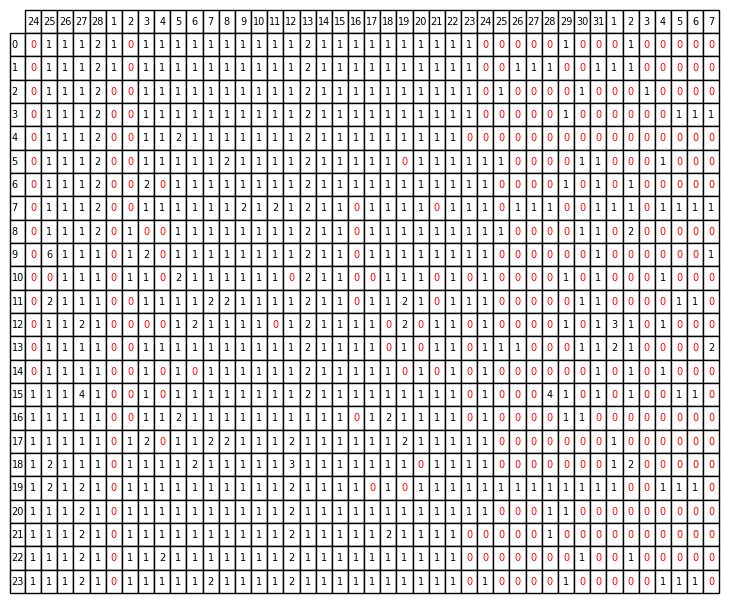

In [46]:
# Create a pivot table to show unique combinations of hour_timestamp and date_timestamp
pivot_table = merged_df.pivot_table(index='hour_timestamp', columns='date_timestamp', values='timestamp', aggfunc='nunique', fill_value=0)

# Convert column index to datetime and extract the day
pivot_table.columns = pd.to_datetime(pivot_table.columns).day

# Print the pivot table with grids and highlight count values of '0' in red font
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pivot_table.values, colLabels=pivot_table.columns, rowLabels=pivot_table.index, cellLoc='center', loc='center')

# Apply styles to the table
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if i > 0 and j > -1 and pivot_table.iat[i-1, j] == 0:
        cell.set_text_props(color='red')

table.auto_set_font_size(True)
table.set_fontsize(8)
table.scale(1.4, 1.4)

plt.show()

In [47]:
# sort df by timestamp, secondly by subarray, thirdly by 'x', to easy interpretation of transformation of x to proper datetime format
merged_df = merged_df.sort_values(by=['timestamp', 'subarray', 'x'])

# ensure conversion from net price to price including taxes..

from datetime import datetime

# Ensure 'x' column is numeric
merged_df['x'] = pd.to_numeric(merged_df['x'], errors='coerce')


# Convert 'x' to a datetime column
merged_df['date_time'] = merged_df['x'].apply(lambda x: datetime.fromtimestamp(x * 100000 / 1000))

print(merged_df)




                 x        y                         timestamp subarray  \
176277  17403516.0     0.01  2025-02-24T15:40:49.845469+00:00        0   
176278  17403552.0  0.01189  2025-02-24T15:40:49.845469+00:00        0   
176279  17403588.0  0.01243  2025-02-24T15:40:49.845469+00:00        0   
176280  17403624.0  0.00768  2025-02-24T15:40:49.845469+00:00        0   
176281  17403660.0  0.00393  2025-02-24T15:40:49.845469+00:00        0   
...            ...      ...                               ...      ...   
73426   17446212.0    0.022  2025-04-07T13:52:15.642990+00:00        5   
73427   17446248.0   -0.001  2025-04-07T13:52:15.642990+00:00        5   
73428   17446284.0   -0.009  2025-04-07T13:52:15.642990+00:00        5   
73429   17446320.0   -0.018  2025-04-07T13:52:15.642990+00:00        5   
73430   17446356.0   -0.006  2025-04-07T13:52:15.642990+00:00        5   

       date_timestamp  hour_timestamp           date_time  
176277     2025-02-24              15 2025-02-24 00

In [48]:
# Build a mapping of year to energy tax rate
years = merged_df['date_time'].dt.year.unique()
energy_tax_rates = {}
for year in sorted(years):
    if year == 2025:
        energy_tax_rates[year] = 0.1228
    else:
        rate_input = input(f"Enter energy tax rate for year {year}: ")
        try:
            energy_tax_rates[year] = float(rate_input)
        except Exception as e:
            print(f"Invalid input, defaulting energy tax rate for {year} to 0.0")
            energy_tax_rates[year] = 0.0

print("Energy tax rates by year:", energy_tax_rates)

Energy tax rates by year: {np.int32(2025): 0.1228}


In [49]:
# applying 2025 tax rate and VAT to calcuate electricity price including taxes
# Ensure 'y' column is numeric
merged_df['y'] = pd.to_numeric(merged_df['y'], errors='coerce')

merged_df['Price'] = merged_df['y'] * 1.21 + energy_tax_rates[2025]
print(merged_df)


                 x        y                         timestamp subarray  \
176277  17403516.0  0.01000  2025-02-24T15:40:49.845469+00:00        0   
176278  17403552.0  0.01189  2025-02-24T15:40:49.845469+00:00        0   
176279  17403588.0  0.01243  2025-02-24T15:40:49.845469+00:00        0   
176280  17403624.0  0.00768  2025-02-24T15:40:49.845469+00:00        0   
176281  17403660.0  0.00393  2025-02-24T15:40:49.845469+00:00        0   
...            ...      ...                               ...      ...   
73426   17446212.0  0.02200  2025-04-07T13:52:15.642990+00:00        5   
73427   17446248.0 -0.00100  2025-04-07T13:52:15.642990+00:00        5   
73428   17446284.0 -0.00900  2025-04-07T13:52:15.642990+00:00        5   
73429   17446320.0 -0.01800  2025-04-07T13:52:15.642990+00:00        5   
73430   17446356.0 -0.00600  2025-04-07T13:52:15.642990+00:00        5   

       date_timestamp  hour_timestamp           date_time     Price  
176277     2025-02-24              15 202

In [55]:
from datetime import datetime

# re-Sort merged_df based on the proper datetime column to avoid plotting errors !!
merged_df = merged_df.sort_values(by=['date_timestamp', 'hour_timestamp', 'date_time'])

print("Sorted head values:")
print(merged_df.head(2))
print()
print("Sorted tail values:")

# Save the DataFrame as a CSV file with the current date in the filename
# Define the path to save the CSV file
output_path = Path("../../src/data/price_predictions_oxygent")
output_path.mkdir(parents=True, exist_ok=True)

current_date = datetime.now().strftime("%Y%m%d")
output_filename = output_path / f"Price_Preds_Processed_{current_date}.csv"
merged_df.to_csv(output_filename, index=False)

print(f"DataFrame saved as '{output_filename}'")



Sorted head values:
                 x      y                         timestamp subarray  \
176277  17403516.0  0.010  2025-02-24T15:40:49.845469+00:00        0   
176326  17403516.0  0.152  2025-02-24T15:40:49.845469+00:00        1   

       date_timestamp  hour_timestamp  date_time    Price  
176277     2025-02-24              15 2025-02-24  0.13490  
176326     2025-02-24              15 2025-02-24  0.30672  

Sorted tail values:
DataFrame saved as '../../src/data/price_predictions_oxygent/Price_Preds_Processed_20250407.csv'


In [51]:
point_est_price_df = merged_df[merged_df['subarray'] == 1]

/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22785/1215119360.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", n_groups)


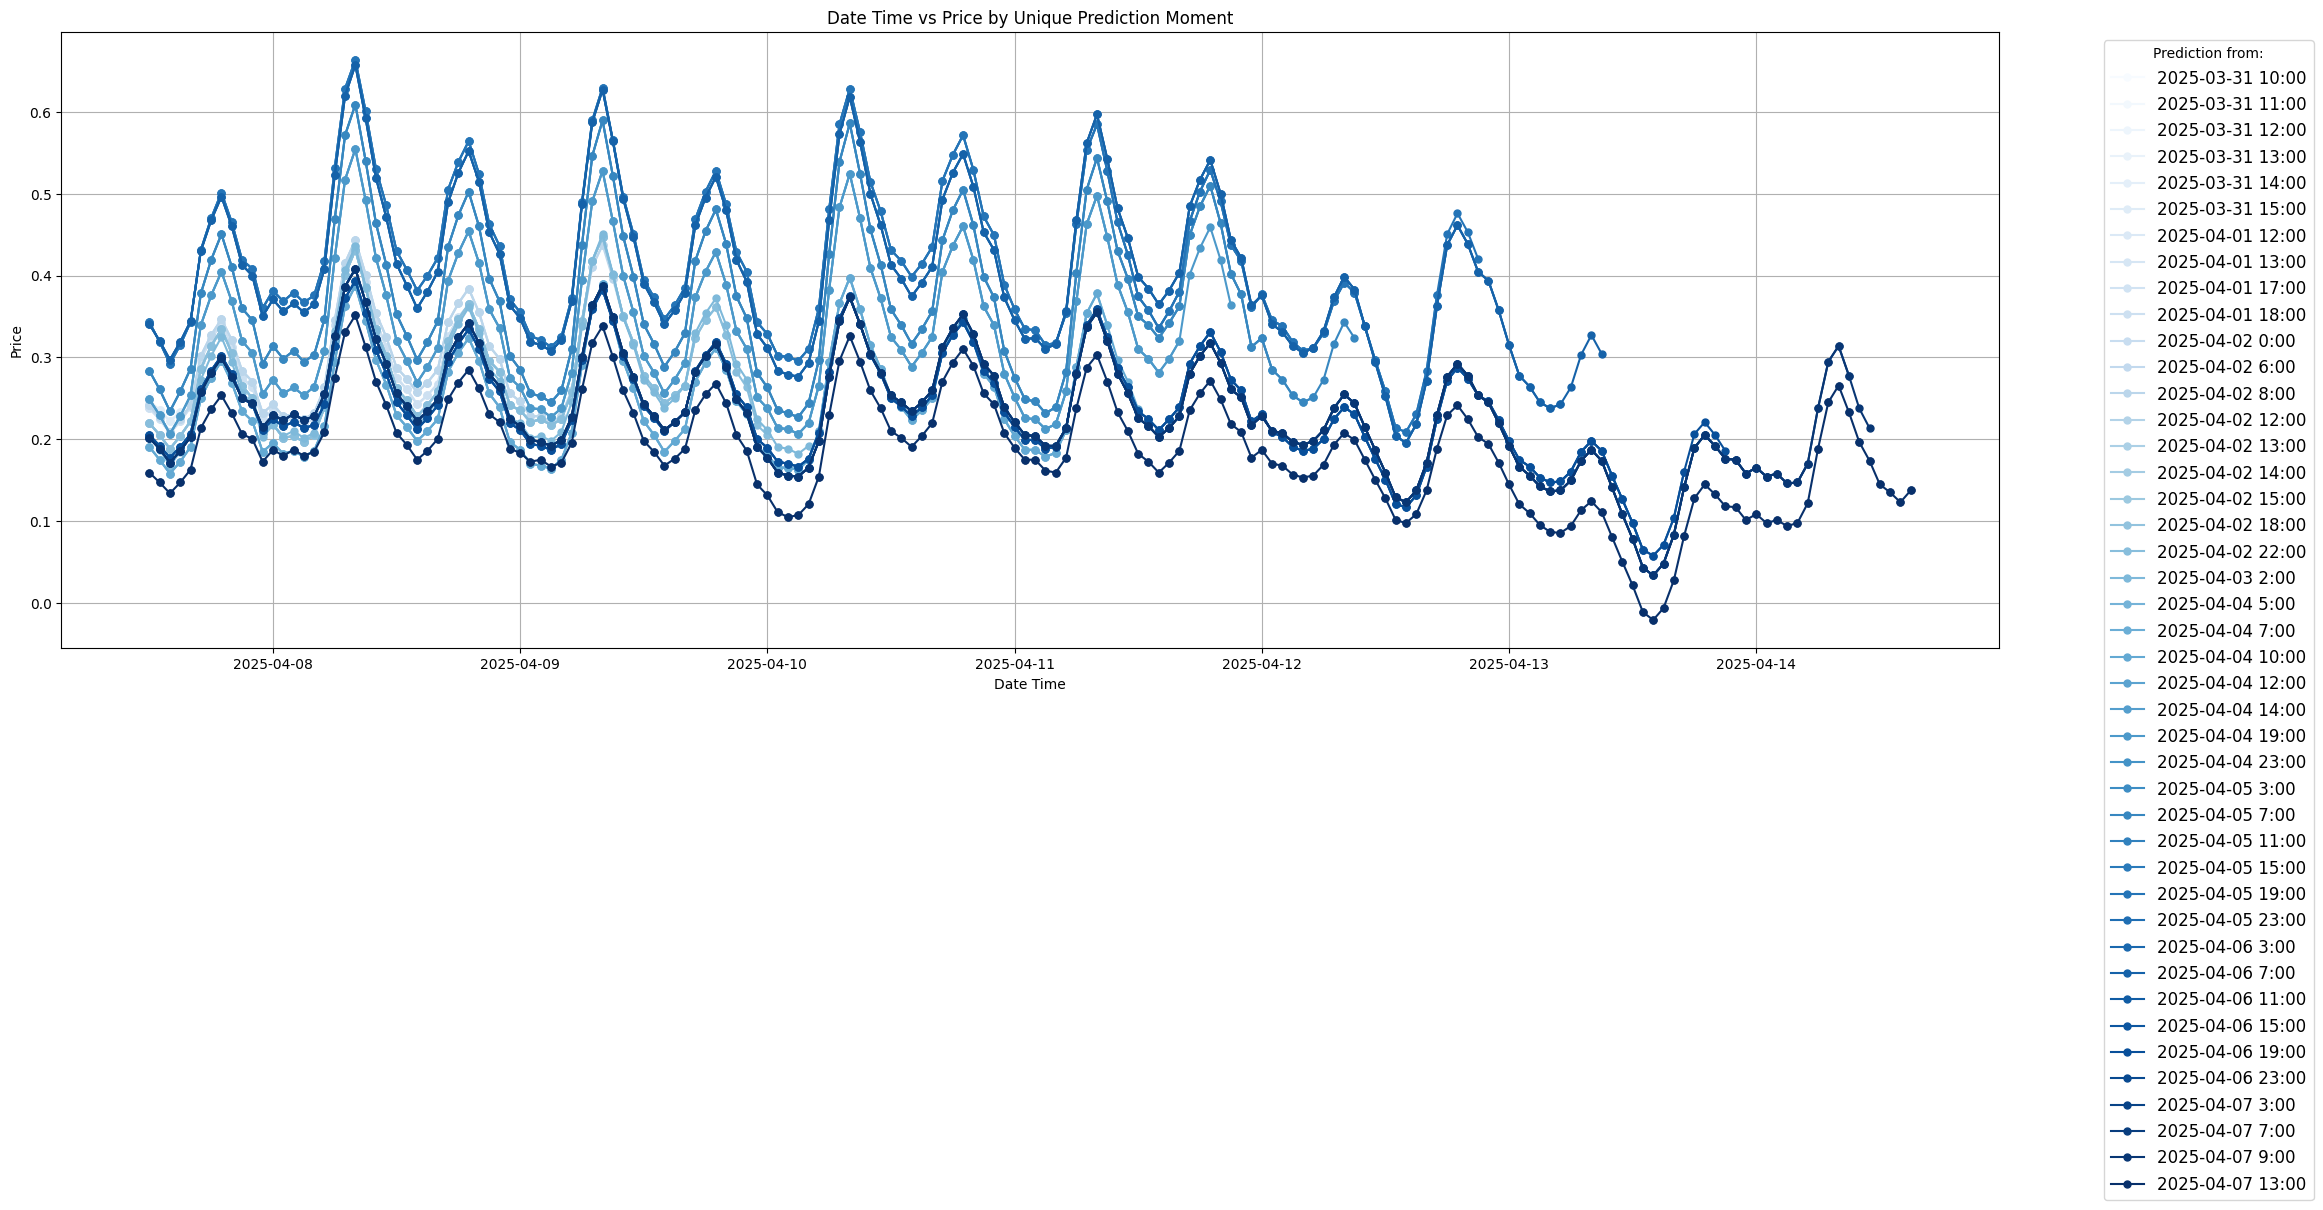

In [52]:


#  how estimate evolve for a particular time period
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import numpy as np

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 12 or 4 or 20
#filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 4) | (filtered_df['hour_timestamp'] == 12) | (filtered_df['hour_timestamp'] == 20)]


# old code #for (date_timestamp, hour_timestamp), group in unique_combinations:
  #  plt.plot(group['date_time'], group['Price'], marker='o', label=f'{date_timestamp} {hour_timestamp}:00')

# Group the filtered data by date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])

# Determine the number of unique groups
n_groups = len(unique_combinations)

# Generate a colormap ranging from light blue to dark blue
cmap = cm.get_cmap("Blues", n_groups)

plt.figure(figsize=(25, 8))  # Adjust the figure size

# Iterate through each unique combination and plot the data
for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    color = cmap(i)  # Assign a color based on the group index
    plt.plot(group['date_time'], group['Price'], color=color, marker='o', markersize=5, linestyle='-', 
             label=f'{date_timestamp} {hour_timestamp}:00')

# Add labels, title, and legend
plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by Unique Prediction Moment')
plt.legend(title='Prediction from:', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)

# Display the plot
plt.show()


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22785/907377483.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", n_groups)


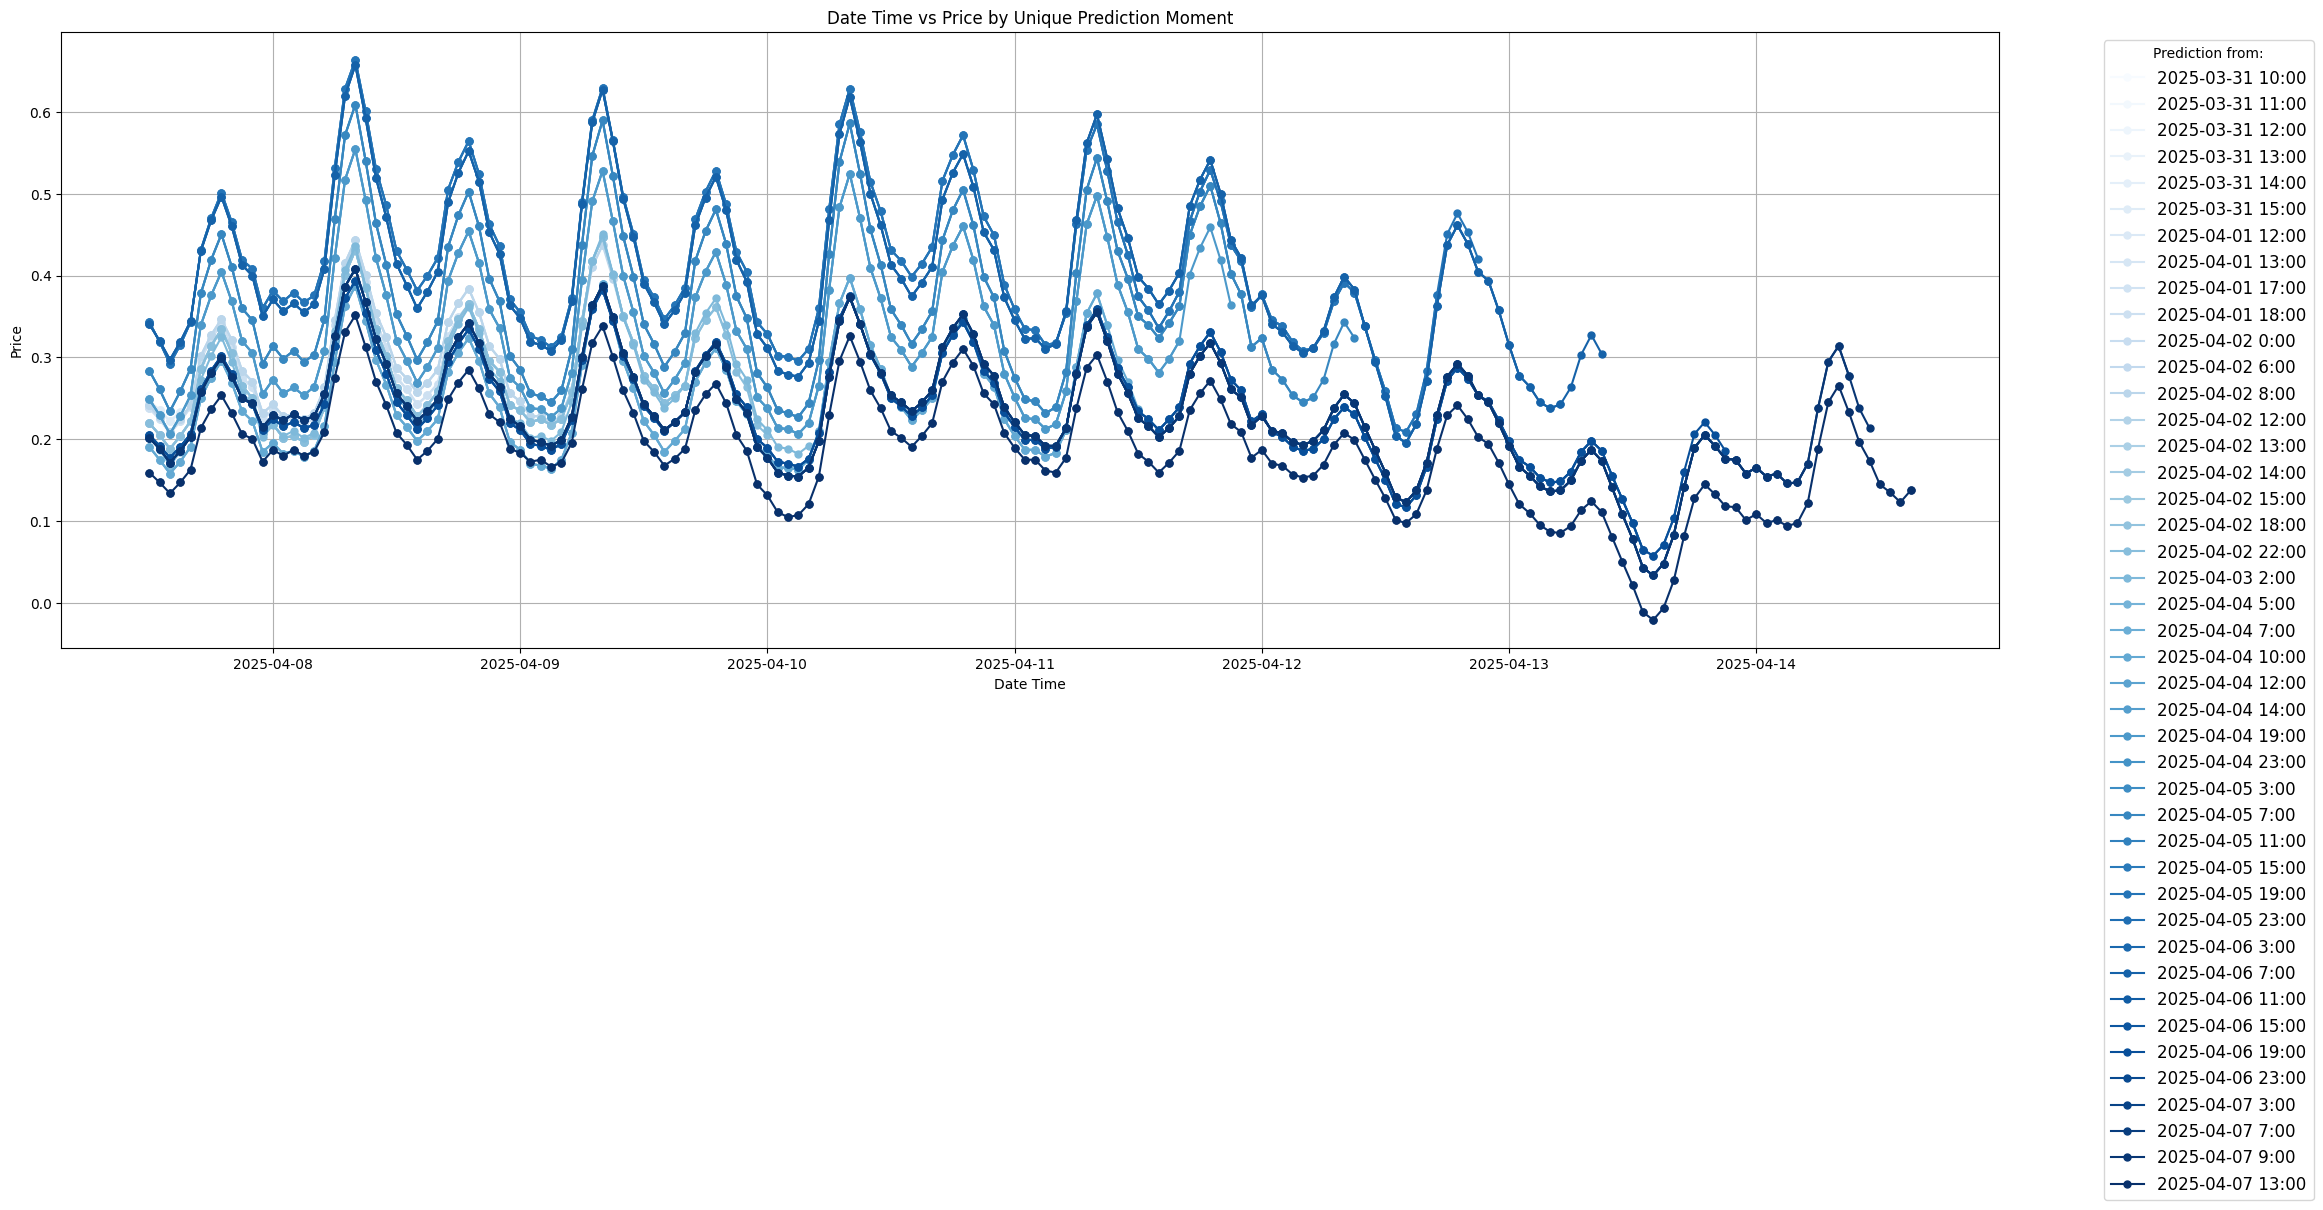

In [53]:


#  how estimate evolve for a particular time period
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 12 or 4 or 20
#filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 4) | (filtered_df['hour_timestamp'] == 12) | (filtered_df['hour_timestamp'] == 20)]


# old code #for (date_timestamp, hour_timestamp), group in unique_combinations:
  #  plt.plot(group['date_time'], group['Price'], marker='o', label=f'{date_timestamp} {hour_timestamp}:00')

# Group the filtered data by date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])

# Determine the number of unique groups
n_groups = len(unique_combinations)

# Generate a colormap ranging from light blue to dark blue
cmap = cm.get_cmap("Blues", n_groups)

plt.figure(figsize=(25, 8))  # Adjust the figure size

# Iterate through each unique combination and plot the data
for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    color = cmap(i)  # Assign a color based on the group index
    plt.plot(group['date_time'], group['Price'], color=color, marker='o', markersize=5, linestyle='-', 
             label=f'{date_timestamp} {hour_timestamp}:00')

# Add labels, title, and legend
plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by Unique Prediction Moment')
plt.legend(title='Prediction from:', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)

# Display the plot
plt.show()